In [3]:
import sys
import os
import importlib
sys.path.append(os.path.abspath('../'))

import uvotimgpy.utils.image_operation
importlib.reload(uvotimgpy.utils.image_operation)
from uvotimgpy.utils.image_operation import DS9Converter, rotate_image, align_images
from uvotimgpy.uvot_image.star_cleaner import BackgroundCleaner
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

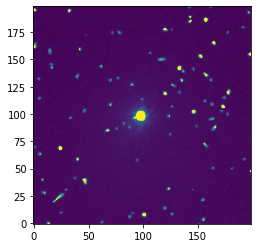

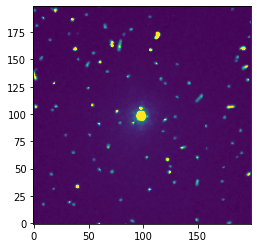

In [5]:
img_dict = {'18':(760,872),
            #'20':(773,884),
            '24':(766,877),
            #'26':(778,889)
            }
img_list = []
target_list = []
for imgid in img_dict.keys():
    x, y = img_dict[imgid]
    hdul = fits.open('/Volumes/ZexiWork/data/HST/29P/2019/'+imgid+'.fits')
    img = hdul[1].data
    angle = float(hdul[1].header['ORIENTAT'])
    col, row = DS9Converter.ds9_to_coords(x, y)[2:]
    target_list.append((col, row))

    img = rotate_image(img, target_coord=(col, row), angle=angle, fill_value=np.nan)
    img_list.append(img)

new_source_coord_ds9 = (100,100)
col, row = DS9Converter.ds9_to_coords(new_source_coord_ds9[0], new_source_coord_ds9[1])[2:]
img_list = align_images(img_list, target_list, (col, row))

for img in img_list:
    plt.imshow(img, vmin=0, vmax=2, origin='lower')
    plt.show()

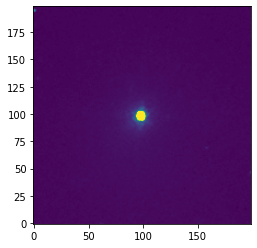

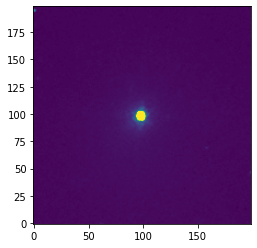

In [6]:
img_a = img_list[0]
img_b = img_list[1]
cleaner = BackgroundCleaner()
cleaned_a, cleaned_b = cleaner.process_image_pair(img_a, img_b)

plt.imshow(cleaned_a, vmin=0, vmax=2, origin='lower')
plt.show()

plt.imshow(cleaned_b, vmin=0, vmax=2, origin='lower')
plt.show()


The two images are almost the same, which indicates a over-mask.

In [2]:
import sys
import os
import importlib
sys.path.append(os.path.abspath('../'))

import uvotimgpy.utils.image_operation
import uvotimgpy.uvot_image.star_cleaner
importlib.reload(uvotimgpy.utils.image_operation)
importlib.reload(uvotimgpy.uvot_image.star_cleaner)
from uvotimgpy.utils.image_operation import DS9Converter, crop_image
from uvotimgpy.uvot_image.star_cleaner import StarIdentifier, PixelFiller
from uvotimgpy.base.visualizer import MaskInspector
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from Ipython.display import display
import numpy as np

ModuleNotFoundError: No module named 'Ipython'

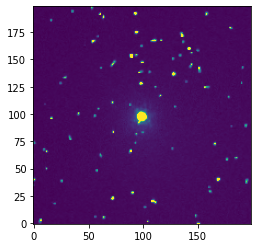

In [3]:
#hdul = fits.open('/Volumes/ZexiWork/data/HST/29P/2019/18.fits')
#x, y = 760, 872
img = hdul[1].data
col, row = DS9Converter.ds9_to_coords(x, y)[2:]
new_source_coord_ds9 = (100,100)
col_new, row_new = DS9Converter.ds9_to_coords(new_source_coord_ds9[0], new_source_coord_ds9[1])[2:]
img_cropped = crop_image(img, (col, row), (col_new, row_new))

plt.imshow(img_cropped, vmin=0, vmax=2, origin='lower')
plt.show()

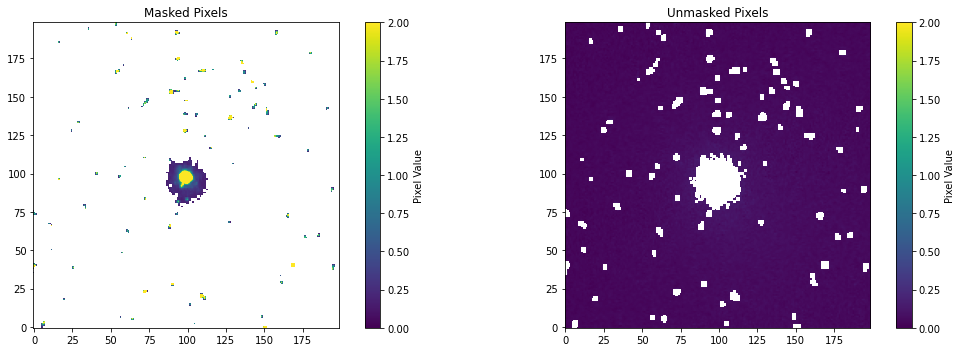

In [4]:
identifier = StarIdentifier()
mask = identifier.by_sigma_clip(img_cropped)

from uvotimgpy.base.visualizer import MaskInspector
inspector = MaskInspector(img_cropped, mask)
inspector.show_comparison(vmin=0,vmax=2)

In [5]:
def plotRing(r, center, color='r', ls='-',lw=0.5,alpha=1):
    theta = np.arange(0,2*np.pi,0.01)
    if isinstance(r, np.ndarray):
        for ri in r:
            plt.plot(ri*np.cos(theta)+center[0],ri*np.sin(theta)+center[1],color=color,ls=ls,lw=lw,alpha=alpha)
    else:
        plt.plot(r*np.cos(theta)+center[0],r*np.sin(theta)+center[1],color=color,ls=ls,lw=lw,alpha=alpha)

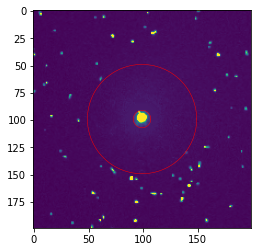

In [7]:
filler = PixelFiller()
step = 2
center_new = (col_new, row_new)
image_filled, radii, values = filler.by_rings(image=img_cropped, mask=mask, center=center_new, step=step, start=2, end=50)
r_min = np.min(radii)-step/2
r_max = np.max(radii)+step/2
%matplotlib inline
plt.imshow(image_filled, vmin=0, vmax=2)
plotRing(np.array([r_min,r_max]),center_new)
plt.show()

In [13]:


identifier = StarIdentifier()
hdulpath = '/Users/zexixing/Research/29P/data/29p_raw_oct/05000049002/uvot/image/sw05000049002uw1_sk.img.gz'
hdul = fits.open(hdulpath)
image = hdul[1].data
wcs = WCS(hdul[1].header)
star_mask = identifier.by_catalog(
    image=image,
    wcs=wcs,
    mag_limit=17,
    catalog='gsc',
    aperture_radius=5
)
hdul.close()

Querying GSC 2.3 catalog...
GSC 2.3 query completed


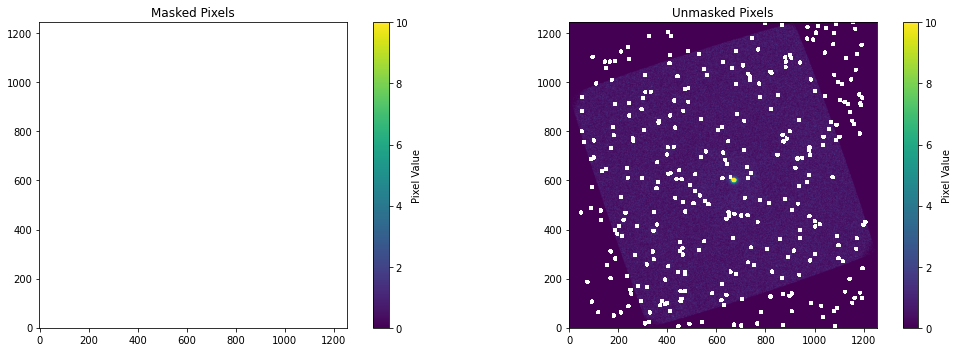

In [14]:
%matplotlib inline
inspector = MaskInspector(image, star_mask)
inspector.show_comparison(vmin=0,vmax=10)

Querying UCAC4 catalog...
UCAC4 query completed


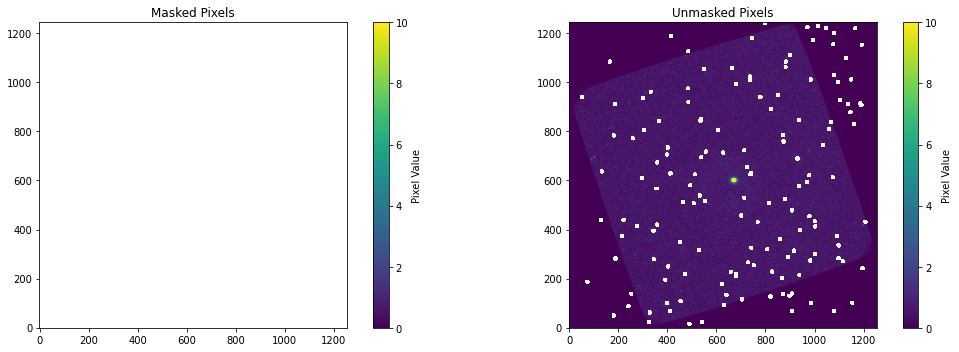

In [23]:
identifier = StarIdentifier()
hdulpath = '/Users/zexixing/Research/29P/data/29p_raw_oct/05000049002/uvot/image/sw05000049002uw1_sk.img.gz'
hdul = fits.open(hdulpath)
image = hdul[1].data
wcs = WCS(hdul[1].header)
star_mask = identifier.by_catalog(
    image=image,
    wcs=wcs,
    mag_limit=17,
    catalog='UCAC4',
    aperture_radius=5
)
hdul.close()
%matplotlib inline
inspector = MaskInspector(image, star_mask)
inspector.show_comparison(vmin=0,vmax=10)

In [20]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from photutils.aperture import CircularAperture
import numpy as np

class ApertureSelector:
    def __init__(self, image_data, vmin=0, vmax=None):
        self.image = image_data
        self.fig, self.ax = plt.subplots()
        self.apertures = []
        self.circles = []
        self.current_radius = 10
        
        # Display parameters
        self.vmin = vmin
        self.vmax = vmax if vmax is not None else np.percentile(image_data, 99)
        
        # Display image and cursor
        self.display = self.ax.imshow(self.image, origin='lower', cmap='viridis',
                                    vmin=self.vmin, vmax=self.vmax)
        self.colorbar = plt.colorbar(self.display)
        
        # Preview circle (initially invisible)
        center = (image_data.shape[1]/2, image_data.shape[0]/2)
        self.preview_circle = Circle(center, self.current_radius, 
                                   fill=False, color='red', linestyle='--', 
                                   alpha=0, visible=False)
        self.ax.add_patch(self.preview_circle)
        
        # Set title with instructions
        self.ax.set_title(
            'Left Click: Select Aperture\n'
            'W/E: Decrease/Increase Radius  V/B: Decrease/Increase Min  N/M: Decrease/Increase Max\n'
            'Z: Undo  R: Reset View  Enter: Finish\n'
            'Arrow Keys: Pan View  I/O: Zoom In/Out'
        )
        
        # Connect events
        self.fig.canvas.mpl_connect('key_press_event', self._onkey)
        self.fig.canvas.mpl_connect('button_press_event', self._onclick)
        
    def _update_display(self):
        self.display.set_clim(vmin=self.vmin, vmax=self.vmax)
        self.fig.canvas.draw()
        
    def _show_preview(self):
        # Get current view center
        xlim = self.ax.get_xlim()
        ylim = self.ax.get_ylim()
        center_x = (xlim[1] + xlim[0]) / 2
        center_y = (ylim[1] + ylim[0]) / 2
        
        # Update preview circle
        self.preview_circle.center = (center_x, center_y)
        self.preview_circle.radius = self.current_radius
        self.preview_circle.set_visible(True)
        self.preview_circle.set_alpha(0.8)
        self.fig.canvas.draw()
        
        # Flash effect (fade out)
        import time
        plt.pause(0.1)  # Show for 0.1 seconds
        self.preview_circle.set_visible(False)
        self.fig.canvas.draw()
        
    def _onclick(self, event):
        if event.inaxes != self.ax:
            return
            
        if event.button == 1:  # Left click
            x, y = event.xdata, event.ydata
            aperture = CircularAperture((x, y), r=self.current_radius)
            self.apertures.append(aperture)
            
            circle = Circle((x, y), self.current_radius, 
                          fill=False, color='red', alpha=0.5)
            self.circles.append(circle)
            self.ax.add_patch(circle)
            self.fig.canvas.draw()
            
    def _onkey(self, event):
        if event.key == 'z':  # Undo
            if self.circles:
                self.circles[-1].remove()
                self.circles.pop()
                self.apertures.pop()
                self.fig.canvas.draw()
                
        elif event.key == 'enter':  # Finish
            plt.close()
            
        elif event.key == 'r':  # Reset view
            self.ax.set_xlim(0, self.image.shape[1])
            self.ax.set_ylim(0, self.image.shape[0])
            self.fig.canvas.draw()
            
        elif event.key in ['left', 'right', 'up', 'down']:  # Pan view
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
            move = (xlim[1] - xlim[0]) * 0.1
            
            if event.key == 'left':
                self.ax.set_xlim(xlim[0] + move, xlim[1] + move)
            elif event.key == 'right':
                self.ax.set_xlim(xlim[0] - move, xlim[1] - move)
            elif event.key == 'up':
                self.ax.set_ylim(ylim[0] - move, ylim[1] - move)
            elif event.key == 'down':
                self.ax.set_ylim(ylim[0] + move, ylim[1] + move)
            self.fig.canvas.draw()
            
        elif event.key in ['i', 'o']:  # Zoom
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
            center_x = (xlim[1] + xlim[0]) / 2
            center_y = (ylim[1] + ylim[0]) / 2
            width = xlim[1] - xlim[0]
            height = ylim[1] - ylim[0]
            
            if event.key == 'i':  # Zoom in
                factor = 0.8
            else:  # Zoom out
                factor = 1.25
                
            self.ax.set_xlim(center_x - width/2 * factor, 
                            center_x + width/2 * factor)
            self.ax.set_ylim(center_y - height/2 * factor, 
                            center_y + height/2 * factor)
            self.fig.canvas.draw()
            
        elif event.key in ['v', 'b', 'n', 'm']:  # Adjust display range
            if event.key == 'v':
                self.vmin -= self.vmax * 0.05  # Allow negative values
            elif event.key == 'b':
                self.vmin = min(self.vmax, self.vmin + self.vmax * 0.05)
            elif event.key == 'n':
                self.vmax = max(self.vmin, self.vmax - self.vmax * 0.05)
            elif event.key == 'm':
                self.vmax += self.vmax * 0.05
            self._update_display()
            print(f"Display range: vmin={self.vmin:.1f}, vmax={self.vmax:.1f}")
            
        elif event.key in ['w', 'e']:  # Adjust radius
            if event.key == 'w':
                self.current_radius = max(1, self.current_radius - 0.5)
            elif event.key == 'e':
                self.current_radius += 0.5
            print(f"Current radius: {self.current_radius:.1f}")
            self._show_preview()
            
    def get_apertures(self):
        plt.show()
        return self.apertures


In [29]:
%matplotlib qt

hdul = fits.open('/Users/zexixing/Research/29P/data/29p_raw_oct/05000049002/uvot/image/sw05000049002uw1_sk.img.gz')
image = hdul[1].data
# 创建测试图像
test_image = np.random.normal(100, 10, (100, 100))
# 添加一些假恒星
for _ in range(10):
    x = np.random.randint(10, 90)
    y = np.random.randint(10, 90)
    test_image[y-2:y+3, x-2:x+3] = 500
    
# 使用选择器
selector = ApertureSelector(image)
apertures = selector.get_apertures()

Current radius: 9.5
Current radius: 9.0
Current radius: 8.5
Current radius: 8.0


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py", line 270, in process
    func(*args, **kwargs)
  File "/var/folders/t0/xpm2hj155lqd8xddgb_2th800000gn/T/ipykernel_84092/2945951694.py", line 149, in _onkey
    self._show_preview()
  File "/var/folders/t0/xpm2hj155lqd8xddgb_2th800000gn/T/ipykernel_84092/2945951694.py", line 62, in _show_preview
    plt.pause(0.1)  # Show for 0.1 seconds
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/pyplot.py", line 529, in pause
    canvas.start_event_loop(interval)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_qt5.py", line 424, in start_event_loop
    raise RuntimeError("Event loop already running")
RuntimeError: Event loop already running


Current radius: 7.5
Current radius: 7.0


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py", line 270, in process
    func(*args, **kwargs)
  File "/var/folders/t0/xpm2hj155lqd8xddgb_2th800000gn/T/ipykernel_84092/2945951694.py", line 149, in _onkey
    self._show_preview()
  File "/var/folders/t0/xpm2hj155lqd8xddgb_2th800000gn/T/ipykernel_84092/2945951694.py", line 62, in _show_preview
    plt.pause(0.1)  # Show for 0.1 seconds
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/pyplot.py", line 529, in pause
    canvas.start_event_loop(interval)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_qt5.py", line 424, in start_event_loop
    raise RuntimeError("Event loop already running")
RuntimeError: Event loop already running


Current radius: 6.5
Current radius: 6.0
Current radius: 5.5
Current radius: 5.0


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py", line 270, in process
    func(*args, **kwargs)
  File "/var/folders/t0/xpm2hj155lqd8xddgb_2th800000gn/T/ipykernel_84092/2945951694.py", line 149, in _onkey
    self._show_preview()
  File "/var/folders/t0/xpm2hj155lqd8xddgb_2th800000gn/T/ipykernel_84092/2945951694.py", line 62, in _show_preview
    plt.pause(0.1)  # Show for 0.1 seconds
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/pyplot.py", line 529, in pause
    canvas.start_event_loop(interval)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_qt5.py", line 424, in start_event_loop
    raise RuntimeError("Event loop already running")
RuntimeError: Event loop already running


Current radius: 4.5
Current radius: 5.0
Current radius: 5.5
Display range: vmin=0.0, vmax=525.0
Display range: vmin=0.0, vmax=551.2
Display range: vmin=0.0, vmax=578.8
Display range: vmin=0.0, vmax=607.8
Display range: vmin=0.0, vmax=638.1
Display range: vmin=0.0, vmax=606.2
Display range: vmin=0.0, vmax=575.9
Display range: vmin=0.0, vmax=547.1
Display range: vmin=0.0, vmax=519.8
Display range: vmin=0.0, vmax=493.8
Display range: vmin=0.0, vmax=469.1


In [30]:
# 打印结果
print(f"Selected {len(apertures)} apertures")

Selected 7 apertures
